# CASSIOPE-FAI-Example
***

**Tutorial :** This tutorial explains how to visualize data from the FAI camera.    
**Mission and Instrument :** FAI (Fast Auroral Imager) on CASSIOPE       
**Astronomical Target :** Auroral emissions    
**Primary Tools :** Python3 script     
**Tutorial Level :** Intermediate 

The script presented here is an example of how to visualize photos taken by the FAI (Fast Auroral Imager) instrument, which measures auroral emissions. The University of Calgary already provide visualization with FAI data via the [HTTP access](https://epop-data.phys.ucalgary.ca/) and the [eDex Web](https://edex.phys.ucalgary.ca/#).

In this tutorial, you will learn a different way of visualizing the pictures of the FAI. The data was extracted with [eDex Web](https://edex.phys.ucalgary.ca/#) of the University of Calgary.

## Library

The following script uses

* *numpy* : mathematical operation and multidimensional array
* *h5py* : open .h5 files
* *pandas* : dataframe structure
* *matplotlib* : plot figures
* *basemap* : plot maps
* *datetime* : manipulate time variables
* *re* : text search
* *os* : search the user's system

## Introduction

Data from photos taken by the FAI are stored in .h5 (HDF5) format. Here's a short script to open, access and view the data. Let's start by extracting the data from an .h5 file.

In [45]:
import numpy as np
import h5py
import pandas as pd

file = "FAI_lv1_NIR_20190501_150819_150819_6.0.0.h5" # path to your file and your file name

with h5py.File(file, 'r') as f:
        lat = np.array(f.get('Pixel Latitudes')) # The latitude of the picture
        lon = np.array(f.get('Pixel Longitudes')) # The longitude of the picture
        keys = f.attrs.keys()
        values = f.attrs.values()
        attributes = pd.DataFrame(values, keys) # The picture's attributes
        image = np.array(f.get('FAI Image')) # The brightness of the picture

Since latitude and longitude data are used for a photo, the last row and column are used to indicate the bottom right corner of the image, so they can be removed for our visualization.

In [46]:
lat = np.delete(lat,lat.shape[0]-1,0) 
lat = np.delete(lat,lat.shape[1]-1,1)
lon = np.delete(lon,lon.shape[0]-1,0) 
lon = np.delete(lon,lon.shape[1]-1,1)

Visualizing the FAI photo is easy using the Matplotlib library. We also have access to a list of operationnal attributes.

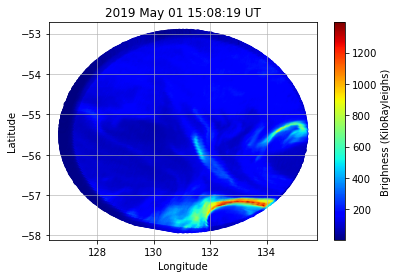

                                                                               0
Attitude Determination Mode                                                    4
CCD Temperature (°C)                                                    -19.8867
Camera Mode                                                      High Resolution
Camera Source                                                  NIR (650-1100 nm)
DN to Rayleigh Conversion Factor (R/DN/s)                                  104.0
Exposure Time (s)                                                            0.1
Image Projection Available                                                  True
Magnetic Latitude (°)                                                 -63.320742
Magnetic Local Time                                                     0.398105
Magnetic Longitude (°)                                               -147.720346
Pitch (°)                                                               -0.25787
Roll (°)                    

In [47]:
import matplotlib.pyplot as plt

plt.grid(True,alpha=0.75)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2019 May 01 15:08:19 UT')
plt.scatter(lon,lat,c=image/1000,cmap='jet')
plt.colorbar(label='Brighness (KiloRayleighs)')
plt.show()
print(attributes)

Note the presence of a halo around the image. To find out more about this halo, there's more information in the [FAI report](https://epop.phys.ucalgary.ca/wp-content/uploads/2021/05/R1-FAI-Characterization-Report.pdf) in section B.14.f. To improve aesthetics, we'll remove this halo by applying a filter to the data. Then, to make things more complex, we'll make a figure where we see the evolution of the FAI photos over time (a few seconds).

## Remove the halo

Photos taken by FAI have an elliptical shape (generally wider than they are tall). The equation for an ellipse is

$$\frac{(x-h)^2}{a^2}+\frac{(y-k)^2}{b^2}=1$$
where
* $(h,k)$ is the center of the ellipse;
* $a$ is the half-measure of the horizontal axis;
* $b$ is the half-measure of the vertical axis.

We'll use this equation to remove the halo. Here is its implementation in Python3.

In [48]:
def ellipse(x,y,a,b,h,k):
    return( (((x-h)**2) / a**2) + (((y-k)**2) / b**2 ))

For example, with the image above, we can estimate the parameters

* $(h,k) = (131.2,-55.4)$
* $a = 4.1$
* $b = 2.3$

for an ellipse that does not include the halo.

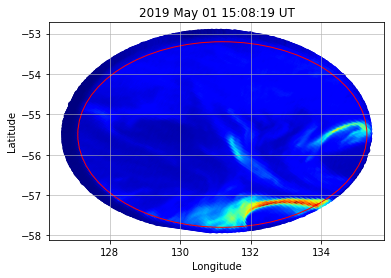

In [49]:
from matplotlib.patches import Ellipse

plt.grid(True,alpha=0.75)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2019 May 01 15:08:19 UT')
plt.scatter(lon,lat,c=image,cmap='jet')
ax = plt.gca()
ax.add_patch(Ellipse((131.2,-55.5), 4.1*2, 2.3*2,ec='red',fc='None'))
plt.show()

The following function removes the halo, i.e. it cancels out anything outside the red line. Most of the time, the halo represents around 5% of the image contour, so we keep 95% of the image. This parameter can be changed to 100% if we don't want to remove the halo.

In [50]:
def ellipseFilter(lon,lat,pct_halo):
    
    # Find the parameters of the elliptic function (without the halo)
    a = (np.nanmax(lon)-lon[139][127])*pct_halo
    b = (np.nanmax(lat)-lat[139][127])*pct_halo
    h = lon[139][127]
    k = lat[139][127]
    
    # For every lat/lon couple, check if there are in the halo 
    # (i.e. if the elliptic equation if greater than 1)
    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]):
                if ellipse(lon[i][j],lat[i][j],a,b,h,k) > 1 :
                    lon[i][j] = np.NAN
                    lat[i][j] = np.NAN            
    
    return(lon,lat)

Here is the final result.

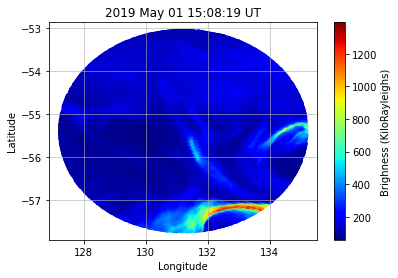

In [51]:
lon, lat = ellipseFilter(lon,lat,0.95)

plt.grid(True,alpha=0.75)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('2019 May 01 15:08:19 UT')
plt.scatter(lon,lat,c=image/1000,cmap='jet')
plt.colorbar(label='Brighness (KiloRayleighs)')
plt.show()

## The evolution of photos over time

The University of Calgary already provides *mp4* videos that allow you to view the images taken by the FAI. As the FAI takes one image per second, it's a nice and interesting animation. However, this makes it difficult to see how a specific point behaves. The rest of the tutorial will help to visualize this situation.

The function takes as parameters the directory and list of files to be viewed and the percentage of the image to be kept (default 95%).

In [52]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.basemap import Basemap

from datetime import datetime as dt
import re
import os

# Create the figure composed of 15 images of the FAI and the satellite's trajectory on a globe
# directory : path were the .h5 files are
# filelist : liste of files to visualize (string) (15 files)
def createPlot(directory,filelist,pct_halo=0.95):
    
    # Create the figure
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize = [9,10], sharex=True, sharey=True)

    # Graduations, colors and titles
    norm, mycmap, conversion = plotSetUp(directory+filelist[7], axs, fig)
    
    # To stock the satellite'S trajectory
    xpos=list()
    ypos=list()

    # Add the pictures within the files
    for index, file in enumerate(filelist) :
       
        filename = directory+file
        
        # Extract the time for the title
        match = re.search(r'(\d+)_(\d+)', file)
        d = dt.strptime(match.group(0), '%Y%m%d_%H%M%S')
        axs[index//4][index%4].set_title(d.time())
        
        # Open the file
        with h5py.File(filename, 'r') as f:
            try:
                lat = np.array(f.get('Pixel Latitudes'))
                lon = np.array(f.get('Pixel Longitudes'))
                image = np.array(f.get('FAI Image'))/conversion
            except:
                lat = np.array(f.get('Pixel_Latitudes'))
                lon = np.array(f.get('Pixel_Longitudes'))
                image = np.array(f.get('FAI_Image'))/conversion
        
        # Adjustments to image (remove last row and column of
        # latitude and longitude)
        lat = np.delete(lat,lat.shape[0]-1,0) 
        lat = np.delete(lat,lat.shape[1]-1,1) 
        
        lon = np.delete(lon,lon.shape[0]-1,0) 
        lon = np.delete(lon,lon.shape[1]-1,1)
        
        # Remove the halo
        lon, lat = ellipseFilter(lon,lat,pct_halo)
        
        # Stock le position of the satellite (the center of the picture)
        xpos.append(lon[139][127])
        ypos.append(lat[139][127])
        
        # Draw image, adjust axes and add grid
        axs[index//4][index%4].scatter(lon,lat,c=image,cmap=mycmap,norm=norm)
        axs[index//4][index%4].xaxis.set_minor_locator(AutoMinorLocator(2))
        axs[index//4][index%4].tick_params(direction='in',length=8,width=1.8,which='both')
        axs[index//4][index%4].grid(color='#7CB9E8', ls='dotted',which='both',alpha=0.7)
    
    # Add a map with CASSIOPE's trajectory
    gs = axs[3][3].get_gridspec()
    axs[3][3].remove()
    mapax = fig.add_subplot(gs[3,3])
    
    m = Basemap(projection='ortho',lon_0 = xpos[7], lat_0 = ypos[7], ax=mapax)
    
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.25)
    m.fillcontinents(color='white',lake_color='#84CBD7')
    m.drawmapboundary(fill_color='#84CBD7')

    m.plot(xpos,ypos,latlon=True,linewidth=3,color='red')
    
    return

Part of the layout has been implemented in a separate function.

In [53]:
# Set graph scales, create colors and titles
# file : the graphs will be centered around this file
# ax : ax used to fix the graduations
# fig : the fig to modify
def plotSetUp(file,axs,fig):
    
    # Figure layout
    plt.subplots_adjust(wspace=0.1, hspace=0.175,bottom=0.17,top=0.93)
    plt.setp(axs,facecolor="lightgrey")
    
    # Add titles
    # Figure's titles
    start_time = re.search(r'(\d+)_(\d+)', filelist[0])
    start_time = dt.strptime(start_time.group(0), '%Y%m%d_%H%M%S')
    end_time = re.search(r'(\d+)_(\d+)', filelist[14])
    end_time = dt.strptime(end_time.group(0), '%Y%m%d_%H%M%S')
    title = start_time.strftime("%Y %b %d %H:%M:%S") + ' - ' + end_time.strftime("%H:%M:%S") + ' UT'
    fig.suptitle(title, size=16)
    
    # The other titles
    fig.text(0.515, 0.137, 'Longitude (Degrés)', ha='center', va='center',size=12)
    fig.text(0.06, 0.55, 'Latitude (Degrés)', ha='center', va='center', rotation='vertical',size=12)
    fig.text(0.5, 0.05, 'Brightness (Data Unit)', ha='center', va='center',size=12)
    
    # Open the file and extract latitude, longitude, 
    # the picture and the Data Unit conversion
    with h5py.File(file, 'r') as f:
        try:
            keys = f.attrs.keys()
            values = f.attrs.values()
            attributes = pd.DataFrame(values, keys)
            conversion = int(attributes.loc['DN to Rayleigh Conversion Factor (R/DN/s)'])           
            image = np.array(f.get('FAI Image'))/conversion
            lat = np.array(f.get('Pixel Latitudes'))
            lon = np.array(f.get('Pixel Longitudes'))            
        except:
            keys = f.attrs.keys()
            values = f.attrs.values()
            attributes = pd.DataFrame(values, keys)
            conversion = int(attributes.loc['DN to Rayleigh Conversion Factor (R/DN/s)'])           
            image = np.array(f.get('FAI_Image'))/conversion
            lat = np.array(f.get('Pixel_Latitudes'))
            lon = np.array(f.get('Pixel_Longitudes')) 

    
    # The norm and colors for the FAI images
    norm = colors.Normalize(vmin=0,vmax=np.nanmax(image))
    cmap = plt.get_cmap('gist_rainbow_r')
    mycmap = colors.LinearSegmentedColormap.from_list('name', cmap(np.linspace(0.12, 0.97)))
    
    # Add the colorbar
    axbar = fig.add_axes([0.2, 0.09, 0.6, 0.02])
    fig.colorbar(cm.ScalarMappable(norm=norm,cmap=mycmap), cax=axbar, orientation="horizontal")
    
    # Set graduations for all images
    gaplat = (np.nanmax(lat)-np.nanmin(lat))*1/10
    gaplon = (np.nanmax(lon)-np.nanmin(lon))*1/10
    axs[1][3].set_ylim(np.nanmin(lat)-gaplat,np.nanmax(lat)+gaplat)
    axs[1][3].set_xlim(np.nanmin(lon)-gaplon,np.nanmax(lon)+gaplon)
    
    axs[2][3].tick_params(labelbottom=True)
    
    return(norm,mycmap,conversion)

Now it's time to test our function. All we need to do is provide the directory where the files are located, the position of the first file in the file list and the time interval (in seconds) between images. We can also choose the percentage of the image we wish to keep (to remove the halo). The filelist needs to always be of 15 files.

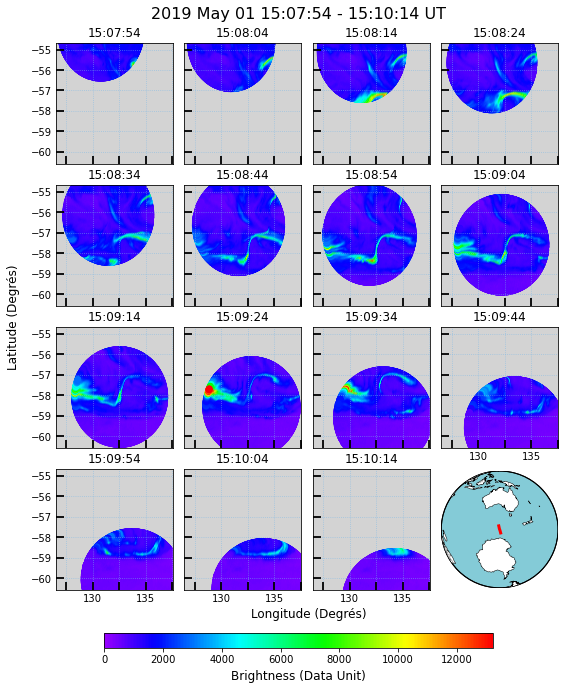

In [54]:
directory = "FAI_lv1_h5_20190501_150534_151306_6.0.0\\" # Path to the .h5 files
firstfile = 140 # The n-th file in the directory
seconds = 10 # Time between pictures
filelist = os.listdir(directory)[firstfile::seconds][0:15] # List of files to create the figure

createPlot(directory,filelist)

In this image, the x and y axes are the same for all figures. Note also that there are 10 seconds between each photo. The bottom right corner shows CASSIOPE's trajectory at that moment. Here's another example to complete this tutorial. Here's another example to finish this tutorial.

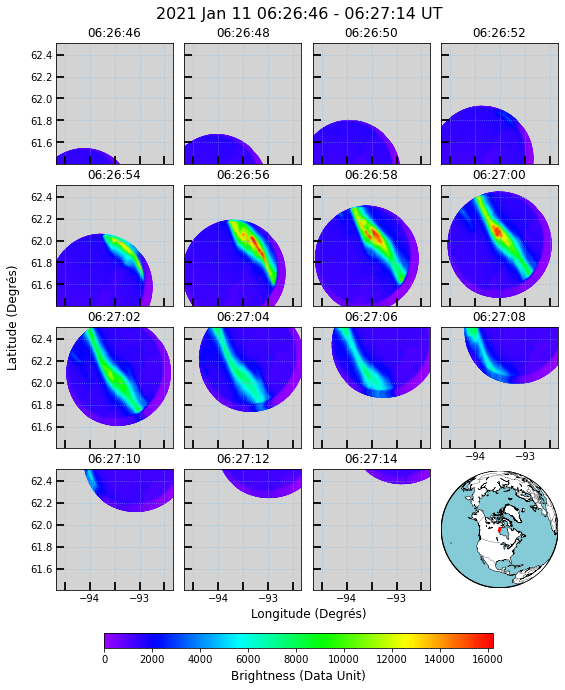

In [55]:
directory = "FAI_lv1_h5_20210111_062314_063145_5.0.0\\" # Path to the .h5 files
firstfile = 212 # The n-th file in the directory
seconds = 2 # Time between pictures
pct_halo = 1 # Pourcentage of the picture we wish to keep
filelist = os.listdir(directory)[firstfile::seconds][0:15] # List of files to create the figure

createPlot(directory,filelist,pct_halo)